Engie Project

Last Update: June 17, 2021

Notes: Considers Unequal Selling / Buying Costs, included residual value and 3 years' worth of buying/selling

Run Time:

In [1]:
### Initialize
import DataFrames, CSV, Plots, JuMP, Gurobi
##Reading in Data
using CSV, DataFrames
Data = CSV.read("Data.csv", DataFrame, normalizenames=true)

,hour,heating_kW_th_h_m2_,PV_electricity_kW,Wind_electricity_kW,Demand_kW
,Float64?,Float64?,Float64?,Float64?,Float64?
1,1.0,0.0,0.0,0.0839,1664.74
2,2.0,0.0001,0.0,0.0839,1551.21
3,3.0,0.0,0.0,0.0839,1429.02
4,4.0,0.0012,0.0,0.0839,1350.95
5,5.0,0.0081,0.0,0.0839,1324.06
6,6.0,0.009,0.0,0.0839,1296.71
7,7.0,0.0139,0.0,0.0839,1597.59
8,8.0,0.0194,0.0,0.1533,1479.02
9,9.0,0.0171,0.0,0.1533,1791.12


In [2]:
##Saving Columns as their variables
ElecDemand = Data[1:8760,5] #kW
ElecDemand = identity.(ElecDemand)

PVMaxPower = 4500 ##kW, 4.5 MW Max Capacity Installed
PV = Data[1:8760,3] #kW/kW Installed
PV = identity.(PV)*PVMaxPower ##KW

Cost_Elec = Data[1:8760,6] 
Cost_Elec = identity.(Cost_Elec)

Cost_Diesel = Data[1:8760,7] #
Cost_Diesel = identity.(Cost_Diesel)

8760-element Array{Float64,1}:
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 ⋮
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119

In [3]:
using JuMP, Gurobi

model = Model(Gurobi.Optimizer)
## Short Term Variables
@variable(model,P_Batt[1:8760],container=Array)
@variable(model,P_Grid[1:8760],container=Array)


@variable(model, P_Sell[1:8760], container=Array)
@variable(model, P_Buy[1:8760], container=Array)
@variable(model, mu[1:8760], binary=true)
@variable(model, P_Diesel[1:8760], container=Array)
#@variable(model, P_NG[1:8760], container=Array)
@variable(model,E_Batt[1:8760],container=Array)

##long term variables
@variable(model, E_Rated)
@variable(model, P_Rated)
@variable(model, P_Rated_Diesel)
#@variable(model, P_Rated_NG)

@variable(model,UseBattery,binary=true)
@variable(model,UseDiesel, binary=true)
#@variable(model,UseNG, binary = true)

Academic license - for non-commercial use only - expires 2021-08-04


UseDiesel

Carbon Tax

In [2]:
# #Carbon Tax Diesel
# Y=3
# Liters = 0.4 * sum(P_Diesel) ## 0.4 L / kWh
# TonsCO2diesel = 2.6* Liters/1000 ## 2.6 kg Co2/ L
# CarbonTaxDiesel = 60*TonsCO2diesel*Y ## Euros per kWh ##EUR 60 per tonne of CO2 mid range bench mark 2020 for OECD
Y=3
# Carbon Tax Natural Gas
#https://www.energuide.be/en/questions-answers/how-much-co2-does-my-home-emit/68/
# 0.198 kg of CO2 per kWh
tonsco2NG = 0.198* sum(P_NG) / 1000
CarbonTaxNG = 60*tonsco2NG*Y

##CarbonTaxGrid
# 0.285 tons per MWh https://www.covenantofmayors.eu/IMG/pdf/technical_annex_en.pdf
Tonsco2grid = 0.285 * sum(P_Buy)/1000
CarbonTaxGrid = PricePerTon* Tonsco2grid

LoadError: [91mUndefVarError: P_NG not defined[39m

Investment Costs

In [5]:
##Battery Investment Costs
CostEnergy = 300 ##euros/kWh
CostPower = 300 ##euros/kW
BIVC = E_Rated*CostEnergy + P_Rated*CostPower

# ##Diesel Investment Costs
# CostDieselPower =400  ##€/kW
# DIVC = P_Rated_Diesel * CostDieselPower

##Natural Gas Investment Costs
CostNGPower = 743 # Euro / kw #https://atb.nrel.gov/electricity/2018/index.html?t=cg
NGIVC = P_Rated_NG*CostNGPower 


400 P_Rated_Diesel

OM 

In [6]:
## Present Value of O&M Costs Battery
CostOMLiIon = 20.5 ## Eurp/kWh/Yr
#Investment Horizon
Y= 3
Discount_Rate = .0025
OMCLiIon=0
for y in Y
    OMCLiIon = OMCLiIon+(E_Rated*CostOMLiIon)/(1+Discount_Rate)^y
end

# ## Present Value of O&M Costs Diesel
# CostOMDiesel = 20 # €/kW/yr
# OMCDiesel=0
# for y in Y
#     OMCDiesel = OMCDiesel+(P_Rated_Diesel*CostOMDiesel)/(1+Discount_Rate)^y
# end

## Present Value of Gas
CostOMNG = 1# €/kW/yr +500 fixed
OMCNG=0
for y in Y
    OMCNG = OMCNG+(500+P_Rated_NG*CostOMNG)/(1+Discount_Rate)^y
end
https://gensetservices.com/wp-content/uploads/2017/11/TCO-_diesel_vs_natural_gas_generators.pdf

Residual value

In [7]:
##Residual Value of Battery at end of investment horizon
DepreciationTime = 10 # Years, from excel sheet
ResidValBatt = (1-Y/DepreciationTime)*BIVC

##Residual Value of Diesel Genset at end of investment horizon
#ResidValDiesel = (1-Y/DepreciationTime)*DIVC

##Residual Value of Natural Gas at end of investment horizon
ResidValNG = (1-Y/DepreciationTime)*NGIVC

280 P_Rated_Diesel

Buying Selling

In [8]:
##GRID
SellingPercent = 0.3 ##Edit this as needed
BuySellTotalCost=0
for y in Y
    BuySellCost = P_Buy.* Cost_Elec +P_Sell.*Cost_Elec*SellingPercent
    BuySellTotalCost = BuySellTotalCost + sum(BuySellCost)/(1+Discount_Rate)^y
end

# ##DIESEL
# DBuyTotalCost=0
# for y in Y
#     DBuyCost = P_Diesel.* Cost_Diesel
#     DBuyTotalCost = DBuyTotalCost + sum(DBuyCost)/(1+Discount_Rate)^y
# end

##Natural Gas
Cost_NG = .0402 #per kWh Natural Gas in Wallonia
Cost_NGFixed = 39.99 #Per Year
NGBuyTotalCost=0

for y in Y
   NGBuyTotalCost = (sum(Cost_NG * P_NG)+Cost_NGFixed)/(1+Discount_Rate)^y
end

#https://www.energyprice.be/blog/gas-price-belgium/

In [9]:
## 0 if not used, *1 if used
OpMainCosts =     UseBattery*OMCLiIon +         UseDiesel*OMCDiesel #+      UseNG*OMCNG
InvestmentCosts = UseBattery*BIVC +             UseDiesel*DIVC #+           UseNG*NGIVC
ResidualValue =   UseBattery*ResidValBatt +     UseDiesel*ResidValDiesel #+ UseNG*ResidValNG
BuyingSelling =   UseBattery*BuySellTotalCost + UseDiesel*DBuyTotalCost #+  UseNG*NGBuyTotalCost
CarbonTax =       UseBattery*0 +                UseDiesel*CarbonTaxDiesel#+ UseNG*CarbonTaxNG

TotalCost = BuyingSelling + OpMainCosts + InvestmentCosts +CarbonTax - ResidualValue

@objective(model, Min, TotalCost)

0.06838582302460529 UseBattery*P_Buy[1] + 0.020515746907381584 UseBattery*P_Sell[1] + 0.0645149273817031 UseBattery*P_Buy[2] + 0.019354478214510928 UseBattery*P_Sell[2] + 0.05985000186333379 UseBattery*P_Buy[3] + 0.017955000559000137 UseBattery*P_Sell[3] + 0.04962686721669469 UseBattery*P_Buy[4] + 0.014888060165008406 UseBattery*P_Sell[4] + 0.04734403132472673 UseBattery*P_Buy[5] + 0.01420320939741802 UseBattery*P_Sell[5] + 0.0476417925280269 UseBattery*P_Buy[6] + 0.01429253775840807 UseBattery*P_Sell[6] + 0.04942835974782791 UseBattery*P_Buy[7] + 0.014828507924348372 UseBattery*P_Sell[7] + 0.05468880767279755 UseBattery*P_Buy[8] + 0.016406642301839264 UseBattery*P_Sell[8] + 0.04446567302615844 UseBattery*P_Buy[9] + 0.01333970190784753 UseBattery*P_Sell[9] + 0.04922985227896113 UseBattery*P_Buy[10] + 0.014768955683688339 UseBattery*P_Sell[10] + 0.054986568876097715 UseBattery*P_Buy[11] + 0.016495970662829314 UseBattery*P_Sell[11] + 0.062132837755301755 UseBattery*P_Buy[12] + 0.01863985

# Power Balance Constraints

In [11]:
##Power Balance
@constraint(model,[i = 1:8760],-ElecDemand[i]+PV[i]+UseBattery*P_Batt[i]+P_Grid[i]+
    UseDiesel*P_Diesel[i]==0 )#+ UseNG*P_NG[i]==0)
# + if pulling from supply, ex P_Batt = +5 means taking 5kW from battery -5 would be saving 5kw

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarQuadraticFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1}:
 UseBattery*P_Batt[1] + UseDiesel*P_Diesel[1] + P_Grid[1] == 1664.7351
 UseBattery*P_Batt[2] + UseDiesel*P_Diesel[2] + P_Grid[2] == 1551.2123
 UseBattery*P_Batt[3] + UseDiesel*P_Diesel[3] + P_Grid[3] == 1429.0156
 UseBattery*P_Batt[4] + UseDiesel*P_Diesel[4] + P_Grid[4] == 1350.9513
 UseBattery*P_Batt[5] + UseDiesel*P_Diesel[5] + P_Grid[5] == 1324.0599
 UseBattery*P_Batt[6] + UseDiesel*P_Diesel[6] + P_Grid[6] == 1296.7088
 UseBattery*P_Batt[7] + UseDiesel*P_Diesel[7] + P_Grid[7] == 1597.5924
 UseBattery*P_Batt[8] + UseDiesel*P_Diesel[8] + P_Grid[8] == 1479.0196
 UseBattery*P_Batt[9] + UseDiesel*P_Diesel[9] + P_Grid[9] == 1791.1166
 UseBattery*P_Batt[10] + UseDiesel*P_Diesel[10] + P_Grid[10] == 1588.4041000000002
 UseBattery*P_Batt[11] + UseDiesel*P_Diesel[11] + P_Grid[11] == 1357.5196
 UseBattery*P_Batt[12] + UseDi

Battery Constraints

In [12]:
## 1 Rated energy and power must be between the min and max
P_Max = 100000 ##kW from excel
P_Min = 600 ##kW from excel
@constraint(model, P_Min <= P_Rated <= P_Max)

## 2 Energy Constraints based on EP ratio
MaxEPRatio=10 ## Ratio from Excel
MinEPRatio=0.25 ##Ratio from Excel
#@constraint(model, (P_Rated*MinEPRatio)<= E_Rated)
#@constraint(model, (P_Rated*MaxEPRatio)>= E_Rated)

## 3 Battery power at time t cannot exceed Rated Power
@constraint(model, [ i=1:8760], P_Batt[i].<= P_Rated)
@constraint(model, [ i=1:8760], P_Batt[i].>= -P_Rated)

## Battery State of Charge Updating with RT Eff and Dissipation Rate
RTEff = 0.90  ## from excel
DissipationRt = 0.00004 ## from excel

@constraint(model, [ i=2:8760], E_Batt[i] == (1-DissipationRt)*E_Batt[i-1]-P_Batt[i]*sqrt(RTEff))

## Charging/discharging power constraints
@constraint(model, [i=1:8760], P_Batt[i] <= P_Rated)
@constraint(model, [i=1:8760], P_Batt[i] >= -P_Rated)

## 5 Energy constraints with depth of discharge
DOD = 0.9
@constraint(model, [i=1:8760], (1-DOD)*E_Rated <= E_Batt[i])
@constraint(model, [i=1:8760],  E_Batt[i] <= E_Rated)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 E_Batt[1] - E_Rated <= 0.0
 E_Batt[2] - E_Rated <= 0.0
 E_Batt[3] - E_Rated <= 0.0
 E_Batt[4] - E_Rated <= 0.0
 E_Batt[5] - E_Rated <= 0.0
 E_Batt[6] - E_Rated <= 0.0
 E_Batt[7] - E_Rated <= 0.0
 E_Batt[8] - E_Rated <= 0.0
 E_Batt[9] - E_Rated <= 0.0
 E_Batt[10] - E_Rated <= 0.0
 E_Batt[11] - E_Rated <= 0.0
 E_Batt[12] - E_Rated <= 0.0
 E_Batt[13] - E_Rated <= 0.0
 ⋮
 E_Batt[8749] - E_Rated <= 0.0
 E_Batt[8750] - E_Rated <= 0.0
 E_Batt[8751] - E_Rated <= 0.0
 E_Batt[8752] - E_Rated <= 0.0
 E_Batt[8753] - E_Rated <= 0.0
 E_Batt[8754] - E_Rated <= 0.0
 E_Batt[8755] - E_Rated <= 0.0
 E_Batt[8756] - E_Rated <= 0.0
 E_Batt[8757] - E_Rated <= 0.0
 E_Batt[8758] - E_Rated <= 0.0
 E_Batt[8759] - E_Rated <= 0.0
 E_Batt[8760] - E_Rated <= 0.0

Diesel Constraints

In [13]:
## 3 Diesel power at time t cannot exceed Rated Power, and cannot be negative
@constraint(model, [i=1:8760],0 <= P_Diesel[i])
@constraint(model, [i=1:8760],P_Diesel[i] <= P_Rated_Diesel)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Diesel[1] - P_Rated_Diesel <= 0.0
 P_Diesel[2] - P_Rated_Diesel <= 0.0
 P_Diesel[3] - P_Rated_Diesel <= 0.0
 P_Diesel[4] - P_Rated_Diesel <= 0.0
 P_Diesel[5] - P_Rated_Diesel <= 0.0
 P_Diesel[6] - P_Rated_Diesel <= 0.0
 P_Diesel[7] - P_Rated_Diesel <= 0.0
 P_Diesel[8] - P_Rated_Diesel <= 0.0
 P_Diesel[9] - P_Rated_Diesel <= 0.0
 P_Diesel[10] - P_Rated_Diesel <= 0.0
 P_Diesel[11] - P_Rated_Diesel <= 0.0
 P_Diesel[12] - P_Rated_Diesel <= 0.0
 P_Diesel[13] - P_Rated_Diesel <= 0.0
 ⋮
 P_Diesel[8749] - P_Rated_Diesel <= 0.0
 P_Diesel[8750] - P_Rated_Diesel <= 0.0
 P_Diesel[8751] - P_Rated_Diesel <= 0.0
 P_Diesel[8752] - P_Rated_Diesel <= 0.0
 P_Diesel[8753] - P_Rated_Diesel <= 0.0
 P_Diesel[8754] - P_Rated_Diesel <= 0.0
 P_Diesel[8755] - P_Rated_Diesel <= 0.0
 P_Diesel[8756] - P_Rated_Diesel <= 0.0
 P_Diesel[8757] - P_

NG constraints

In [14]:
#@constraint(model, [i=1:8760],0 <= P_NG[i])
#@constraint(model, [i=1:8760],P_NG[i] <= P_Rated_NG)

Grid Constraints -- Until 2024

In [15]:
## 6 Grid can only provide 2MW = 2000 kW until 2024
@constraint(model, [i=1:8760],-2000 <= P_Grid[i])
@constraint(model, [i=1:8760],P_Grid[i] <= 2000)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Grid[1] <= 2000.0
 P_Grid[2] <= 2000.0
 P_Grid[3] <= 2000.0
 P_Grid[4] <= 2000.0
 P_Grid[5] <= 2000.0
 P_Grid[6] <= 2000.0
 P_Grid[7] <= 2000.0
 P_Grid[8] <= 2000.0
 P_Grid[9] <= 2000.0
 P_Grid[10] <= 2000.0
 P_Grid[11] <= 2000.0
 P_Grid[12] <= 2000.0
 P_Grid[13] <= 2000.0
 ⋮
 P_Grid[8749] <= 2000.0
 P_Grid[8750] <= 2000.0
 P_Grid[8751] <= 2000.0
 P_Grid[8752] <= 2000.0
 P_Grid[8753] <= 2000.0
 P_Grid[8754] <= 2000.0
 P_Grid[8755] <= 2000.0
 P_Grid[8756] <= 2000.0
 P_Grid[8757] <= 2000.0
 P_Grid[8758] <= 2000.0
 P_Grid[8759] <= 2000.0
 P_Grid[8760] <= 2000.0

In [16]:
## Binary, for buying and selling
@constraint(model, [i=1:8760], P_Grid[i]==P_Sell[i]+P_Buy[i]) ##either selling or buying
##Ex. Selling = -5 kw cannot exceed -2000kW
@constraint(model, [i=1:8760], -PV[i] <= P_Sell[i]) ## Selling only from PV production
@constraint(model, [i=1:8760], -2000*mu[i] <= P_Sell[i])
@constraint(model, [i=1:8760], P_Sell[i] <= 0)
@constraint(model, [i=1:8760], 0 <= P_Buy[i])
@constraint(model, [i=1:8760], P_Buy[i] <= 2000*(1-mu[i]))

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Buy[1] + 2000 mu[1] <= 2000.0
 P_Buy[2] + 2000 mu[2] <= 2000.0
 P_Buy[3] + 2000 mu[3] <= 2000.0
 P_Buy[4] + 2000 mu[4] <= 2000.0
 P_Buy[5] + 2000 mu[5] <= 2000.0
 P_Buy[6] + 2000 mu[6] <= 2000.0
 P_Buy[7] + 2000 mu[7] <= 2000.0
 P_Buy[8] + 2000 mu[8] <= 2000.0
 P_Buy[9] + 2000 mu[9] <= 2000.0
 P_Buy[10] + 2000 mu[10] <= 2000.0
 P_Buy[11] + 2000 mu[11] <= 2000.0
 P_Buy[12] + 2000 mu[12] <= 2000.0
 P_Buy[13] + 2000 mu[13] <= 2000.0
 ⋮
 P_Buy[8749] + 2000 mu[8749] <= 2000.0
 P_Buy[8750] + 2000 mu[8750] <= 2000.0
 P_Buy[8751] + 2000 mu[8751] <= 2000.0
 P_Buy[8752] + 2000 mu[8752] <= 2000.0
 P_Buy[8753] + 2000 mu[8753] <= 2000.0
 P_Buy[8754] + 2000 mu[8754] <= 2000.0
 P_Buy[8755] + 2000 mu[8755] <= 2000.0
 P_Buy[8756] + 2000 mu[8756] <= 2000.0
 P_Buy[8757] + 2000 mu[8757] <= 2000.0
 P_Buy[8758] + 2000 mu[8758] <= 2000.

In [17]:
optimize!(model)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 148920 rows, 61326 columns and 262799 nonzeros
Model fingerprint: 0x65bd2834
Model has 26275 quadratic objective terms
Model has 8760 quadratic constraints
Variable types: 52564 continuous, 8762 integer (8762 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-05, 3e+02]
  Bounds range     [6e+02, 1e+05]
  RHS range        [6e+00, 4e+03]
  QRHS range       [1e-01, 4e+03]
Presolve removed 89560 rows and 19396 columns
Presolve time: 0.83s
Presolved: 85642 rows, 68213 columns, 213484 nonzeros
Presolved model has 17522 SOS constraint(s)
Variable types: 55209 continuous, 13004 integer (13004 binary)
Found heuristic solution: objective 8.090331e+07
Found heuristic solution: objective 7.173140e+07

Determi

In [18]:
println("Optimal Solutions:")
println("Total Cost = ", value(TotalCost))
println("Use Battery? = ", value(UseBattery))
println("Rated Battery Power = ", value(P_Rated)," kW")
println("Battery Cap = ", value(E_Rated)," kWh")
println("Use Diesel? = ", value(UseDiesel))
println("Rated Diesel Power = ", value(P_Rated_Diesel), " kW")
#println("Use Natural Gas? = ", value(UseNG))
#println("Rated Gas Power = ", value(P_Rated_NG)," kW")


Optimal Solutions:
Total Cost = 1.8868489925695471e6
Use Battery? = 1.0
Rated Battery Power = 828.4343999999983 kW
Battery Cap = 4883.280882597266 kWh
Use Diesel? = 1.0
Rated Diesel Power = 928.2360399951125 kW


In [195]:
E_Batt_Optimized = JuMP.value.(E_Batt)
P_Batt_Optimized = JuMP.value.(P_Batt)
P_Grid_Optimized = JuMP.value.(P_Grid)
P_Buy_Optimized = JuMP.value.(P_Buy)
P_Sell_Optimized = JuMP.value.(P_Sell)
P_Diesel_Optimized = JuMP.value.(P_Diesel)
P_NG_Optimized = JuMP.value.(P_NG)

8760-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

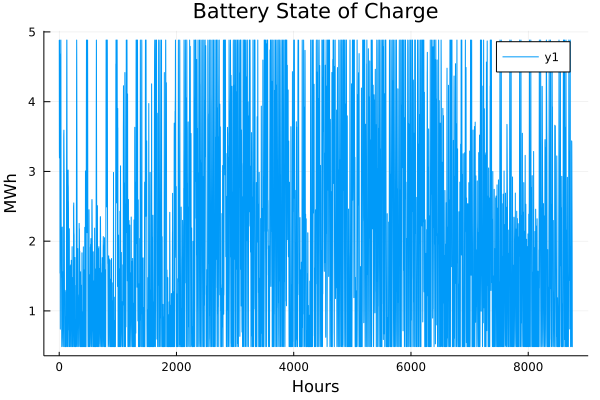

In [201]:
##Battery State of Charge 
using Plots
x = 1:8760
plot(x,E_Batt_Optimized/1000, title = "Battery State of Charge")
xlabel!("Hours")
ylabel!("MWh")

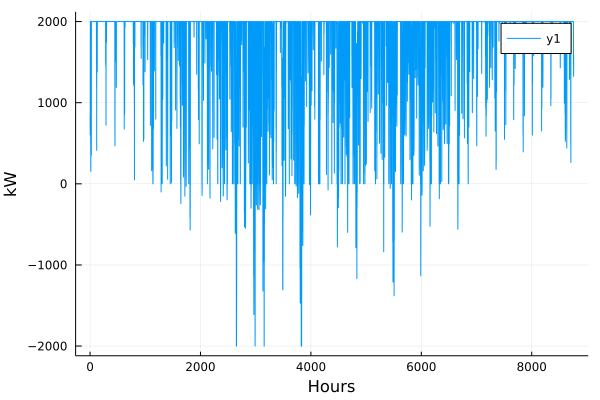

In [197]:
using Plots

plot(x, P_Grid_Optimized)
#plot!(x,P_Sell_Optimized)
#plot!(x,P_Batt_Optimized)
xlabel!("Hours")
ylabel!("kW")

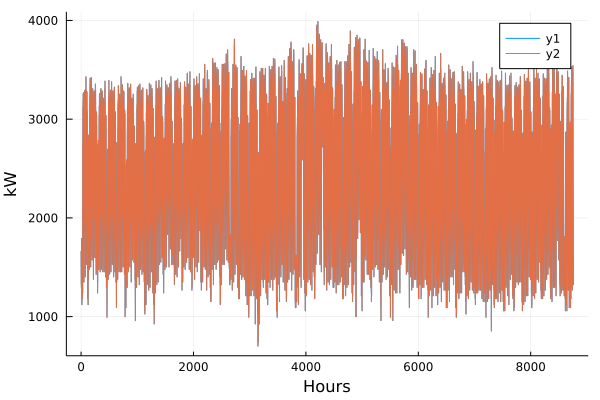

In [198]:
##checking that demand is met
plot(x, ElecDemand)
check = P_Grid_Optimized + P_Batt_Optimized + PV + P_Diesel_Optimized+ P_NG_Optimized
plot!(x,check)
xlabel!("Hours")
ylabel!("kW")

In [202]:
using DataFrames
df = DataFrame( E_Batt = E_Batt_Optimized,
                P_Batt = P_Batt_Optimized,
                P_Grid = P_Grid_Optimized,
                P_Buy = P_Buy_Optimized,
                P_Sell = P_Sell_Optimized,
                PV = PV,
                P_Diesel = P_Diesel_Optimized,
                P_NG = P_NG_Optimized,
                Demand = ElecDemand,
                Binary = JuMP.value.(mu)
               )

,E_Batt,P_Batt,P_Grid,P_Buy,P_Sell,PV,P_Diesel,P_NG,Demand
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,4883.28,828.434,836.301,836.301,0.0,0.0,0.0,0.0,1664.74
2,4097.16,828.434,722.778,722.778,0.0,0.0,0.0,0.0,1551.21
3,3311.08,828.434,600.581,600.581,0.0,0.0,0.0,0.0,1429.02
4,3193.53,123.766,1227.19,1227.19,0.0,0.0,0.0,0.0,1350.95
5,3834.66,-675.94,2000.0,2000.0,0.0,0.0,0.0,0.0,1324.06
6,4501.7,-703.291,2000.0,2000.0,0.0,0.0,0.0,0.0,1296.71
7,4883.28,-402.408,2000.0,2000.0,0.0,0.0,0.0,0.0,1597.59
8,4097.16,828.434,650.585,650.585,0.0,0.0,0.0,0.0,1479.02
9,4295.16,-208.883,2000.0,2000.0,0.0,0.0,0.0,0.0,1791.12


In [203]:
using CSV
CSV.write("Desktop\\OTESALToutputnew.csv", df)

"Desktop\\OTESALToutputnew.csv"